In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy.random as random

# computation scenario
B = 1
# input shape
C_i, H_i, W_i = 64, 224, 224
# output shape
C_o, H_o, W_o = 64, 224, 224

kernel_size, stride, padding = 3, 1, 1

conv_params = (B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding)

scale = 100000  # shape (scale, n) for generating random variables, n values per group

mu_m, theta_m = 5e9, 5e-9

generate_data = True
actual = True

def search_optimal_k(system_params, conv_params, n):
    '''
    对于给定的系统参数以及卷积参数（计算场景参数），返回实际以及估计的最优的(n,k) pair以及对应的时延
    '''
    assert len(system_params) == 6
    assert len(conv_params) == 10
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    mu_rec_n = mu0_rec / n
    mu_sen_n = mu0_sen / n
    theta_rec_n = theta0_rec * n
    theta_sen_n = theta0_sen * n
    if generate_data:
        Es_kth_Ts_w = []
        Es_sum_kth= []
        k0 = 2
        for k in range(k0, n):
            Wpo = W_o / k
            Wpi = kernel_size + (Wpo - 1) * stride

            Nenc = np.prod([(2 * k - 1), n, B, C_i, H_i, Wpi])  # in FLOPs (floating point operations)
            Ndec = np.prod([(2 * k - 1), k, B, C_o, H_o, Wpo])  # in FLOPs
            Nconv = np.prod([B, C_o, H_o, Wpo, C_i, kernel_size ** 2]) \
                        + np.prod([B, C_o, H_o, Wpo, C_i * (kernel_size ** 2)])  # in FLOPs
            Nin = np.prod([B, C_i, H_i, Wpi, 4])  # in bytes
            Nout = np.prod([B, C_o, H_o, Wpo, 4])  # in bytes

            # Tenc = 2 / mu_m + Nenc * theta_m  # ???
            # Tdec = 2 / mu_m + Ndec * theta_m
            Tenc = (1 / mu_m + theta_m) * Nenc
            Tdec = (1 / mu_m + theta_m) * Ndec
            Tm = Tenc + Tdec

            _murec = Nin / mu_rec_n
            _mucmp = Nconv / mu_cmp
            _musen = Nout / mu_sen_n

            Ts_rec = random.exponential(_murec, (scale, n))
            Ts_cmp = random.exponential(_mucmp, (scale, n))
            Ts_sen = random.exponential(_musen, (scale, n))

            Ts_w = Ts_rec + Ts_cmp + Ts_sen
            sum_offset = Nin * theta_rec_n + Nconv * theta_cmp + Nout * theta_sen_n
            
            # kth order statistic of Ts_w, Ts_rec, Ts_cmp, Ts_sen (合起来求o.s.)
            kth_Ts_w = np.partition(Ts_w, k - 1, axis=1)[:, k - 1]
            E_kth_Ts_w = np.mean(kth_Ts_w) + sum_offset + Tm
            Es_kth_Ts_w.append(E_kth_Ts_w)
            # 分开求order statistic
            kth_Ts_rec = np.partition(Ts_rec, k - 1, axis=1)[:, k - 1]
            kth_Ts_cmp = np.partition(Ts_cmp, k - 1, axis=1)[:, k - 1]
            kth_Ts_sen = np.partition(Ts_sen, k - 1, axis=1)[:, k - 1]

            # estimation
            sum_kth_Ts = kth_Ts_rec + kth_Ts_cmp + kth_Ts_sen
            E_sum_kth = np.mean(sum_kth_Ts) + sum_offset + Tm
            Es_sum_kth.append(E_sum_kth)

        optimal_k_actual = k0 + np.argmin(Es_kth_Ts_w)
        ETc_actual = np.min(Es_kth_Ts_w)
        ETc_n_k_actual = (ETc_actual, n, optimal_k_actual)

        optimal_k_estimated = k0 + np.argmin(Es_sum_kth)
        ETc_estimated = np.min(Es_sum_kth)
        ETc_n_k_estimated = (ETc_estimated, n, optimal_k_estimated)
    
    return ETc_n_k_actual, ETc_n_k_estimated


In [8]:
mus_tr = [1e6, 1e7, 5e9]  # 传输参数的初始值
thetas_tr = [1e-7, 1e-8, 1e-10]
mus_cmp = [1e7, 1e8, 1e9]
thetas_cmp = [1e-7, 1e-8, 1e-9]

mu_tr = mus_tr[1]
theta_tr = thetas_tr[1]
mu_cmp = mus_cmp[-1]
theta_cmp = thetas_cmp[-1]

mu0_tr = mus_tr[-1]
theta0_tr = thetas_tr[-1]
mu_cmp = mus_cmp[-1]
theta_cmp = thetas_cmp[-1]

system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
ns = range(10, 50)

# solutions = [search_optimal_k(system_params, conv_params, n) for n in ns]
ks_actual = []
ks_approx = []

ETc_actual = []
ETc_approx = []

for n in tqdm(ns):
    solution_actual, solution_approx = search_optimal_k(system_params, conv_params, n)
    ks_actual.append(solution_actual[-1])
    ks_approx.append(solution_approx[-1])
    ETc_actual.append(solution_actual[0])
    ETc_approx.append(solution_approx[0])

print(ks_actual)
print(ks_approx)


100%|██████████| 40/40 [04:21<00:00,  6.53s/it]

[6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [9]:
# 直接公式近似的再画一遍
def estimated_latency_n(C_i, H_i, C_o, H_o, W_o, kernel_size, stride,
                      mu_m, theta_m, mu_cmp, theta_cmp, mu0_rec, theta0_rec, mu0_sen, theta0_sen, n, k):
    
    
    mu_rec = mu0_rec / n
    mu_sen = mu0_sen / n
    theta_rec = theta0_rec * n
    theta_sen = theta0_sen * n

    Wpo = W_o / k
    Wpi = kernel_size + (Wpo - 1) * stride

    # Nenc = np.prod([(2 * k - 1), n, B, C_i, H_i, Wpi])  # in FLOPs (floating point operations)
    # Ndec = np.prod([(2 * k - 1), k, B, C_o, H_o, Wpo])  # in FLOPs
    # Nconv = np.prod([B, C_o, H_o, Wpo, C_i, kernel_size ** 2]) \
    #             + np.prod([B, C_o, H_o, Wpo, C_i * (kernel_size ** 2)])  # in FLOPs
    # Nin = np.prod([B, C_i, H_i, Wpi, 4])  # in bytes
    # Nout = np.prod([B, C_o, H_o, Wpo, 4])  # in bytes
    
    # result = Nenc * 
    result = ((2*k-1)*n*C_i*H_i*(kernel_size+(W_o/k-1)*stride) + (2*k-1)*C_o*H_o*W_o)*(1/mu_m + theta_m) \
        +4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)*theta_rec + 4*C_o*H_o*W_o/k*theta_sen + C_o*H_o*W_o/k*2*C_i*(kernel_size**2)*theta_cmp \
        +(4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)/mu_rec + 4*C_o*H_o*W_o/(k*mu_sen) + C_o*H_o*W_o*2*C_i*(kernel_size**2)/(k*mu_cmp))*np.log(n/(n-k))
    return result

ks_estimated = []
ETc_estimated = []

for n in ns:
    k_range = range(2, n)
    estimated_ETcs = [estimated_latency_n(C_i, H_i, C_o, H_o, W_o, kernel_size, stride,
                                        mu_m, theta_m, mu_cmp, theta_cmp, mu0_tr, theta0_tr, mu0_tr, theta0_tr, n, k) for k in k_range]
    min_estimated_ETc = np.min(estimated_ETcs)
    ETc_estimated.append(min_estimated_ETc)
    k_estimated = np.argmin(estimated_ETcs) + 2
    ks_estimated.append(k_estimated)

print(ks_estimated)

[6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


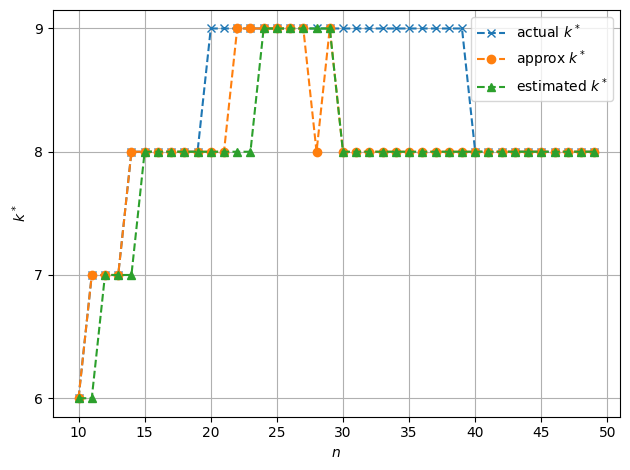

In [10]:
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.plot(ns, ks_actual, 'x--', label=r'actual $k^*$')
plt.plot(ns, ks_approx, 'o--', label=r'approx $k^*$')
plt.plot(ns, ks_estimated, '^--', label=r'estimated $k^*$')
plt.xlabel('$n$')
plt.ylabel('$k^*$')
plt.legend()
plt.tight_layout()
plt.show()

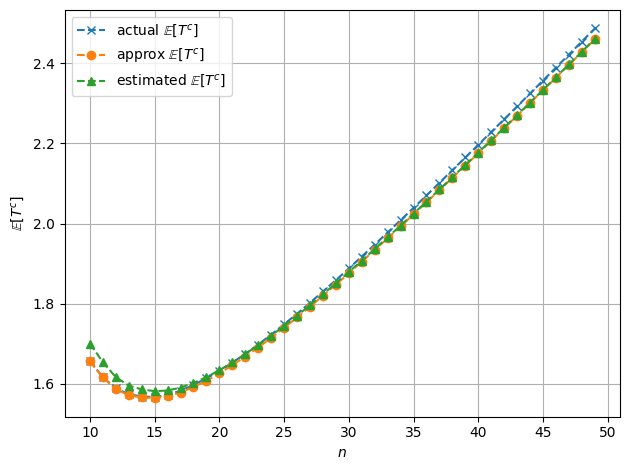

In [13]:
plt.grid()
plt.plot(ns, ETc_actual, 'x--', label=r'actual $\mathbb{E}[T^c]$')
plt.plot(ns, ETc_approx, 'o--', label=r'approx $\mathbb{E}[T^c]$')
plt.plot(ns, ETc_estimated, '^--', label=r'estimated $\mathbb{E}[T^c]$')
plt.xlabel('$n$')
plt.ylabel(r'$\mathbb{E}[T^c]$')
plt.legend()
plt.tight_layout()
plt.show()